In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct


In [2]:
import datashader.transfer_functions as tf
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import dynspread
from holoviews.operation.datashader import datashade
import hvplot

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)
width, height = plt.rcParams.get('figure.figsize')

In [4]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
import seaborn as sns

In [5]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [6]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

In [7]:
def divv(Vx, Vy, stepsize):
    dvx_dx = np.gradient(Vx, axis=0)/stepsize
    dvy_dy = np.gradient(Vy, axis=1)/stepsize

    DIV = dvx_dx + dvy_dy
    return DIV

def rotorr(Vx, Vy, stepsize):
    dvx_dy = np.gradient(Vx, axis=1)/stepsize
    dvy_dx = np.gradient(Vy, axis=0)/stepsize

    ROTOR = dvy_dx - dvx_dy
    return ROTOR

In [8]:
Vxm1 = fits.open("VelocitiesRS_TAU_0_100.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("VelocitiesRS_TAU_0_100.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm1 = fits.open("VelocitiesRS_TAU_0_100.fits")[2].data
Vxm1 = Vxm1[::3,::2,::2]/1E5
Vym1 = Vym1[::3,::2,::2]/1E5
Vzm1 = Vzm1[::3,::2,::2]/1E5
#Vxm1 = Vxm1.transpose(0, 2, 1)
#Vym1 = Vym1.transpose(0, 2, 1)
#Vzm1 = Vzm1.transpose(0, 2, 1)

In [9]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[0].data
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[1].data
Vx_Bz1 = Vx_Bz1[:30,::2,::2]
Vy_Bz1 = Vy_Bz1[:30,::2,::2]

In [10]:
Vx_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[0].data
Vy_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[1].data
Vx_Bz2 = Vx_Bz2[:30,::2,::2]
Vy_Bz2 = Vy_Bz2[:30,::2,::2]

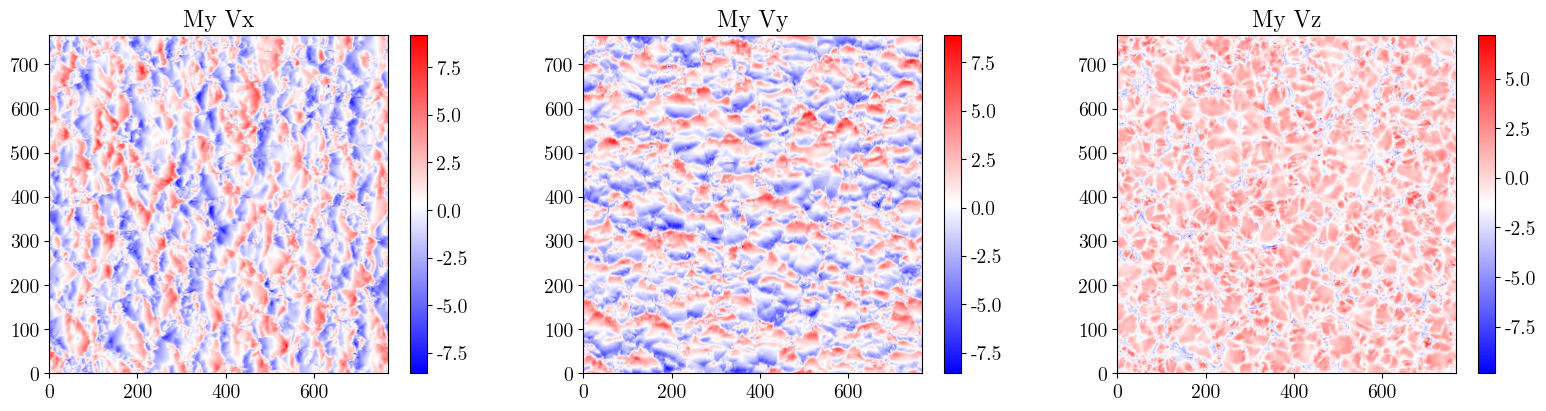

In [11]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(Vxm1[0], origin = "lower", cmap = "bwr")
plt.title("My Vx")
plt.colorbar()
plt.subplot(132)
plt.imshow(Vym1[0], origin = "lower", cmap = "bwr")
plt.title("My Vy")
plt.colorbar()
plt.subplot(133)
plt.imshow(Vzm1[0], origin = "lower", cmap = "bwr")
plt.title("My Vz")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [12]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data

In [13]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [14]:
Vxm1_filtered600 = gaussian_filter(Vxm1_mean, 22.5/2, mode = "wrap")
Vym1_filtered600 = gaussian_filter(Vym1_mean, 22.5/2, mode = "wrap")

In [15]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25/2, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25/2, mode = "wrap")

In [16]:
Vxm2 = fits.open("VelocitiesRS_TAU_0_010.fits")[1].data # Vy from Velocities.fits as originally thought
Vym2 = fits.open("VelocitiesRS_TAU_0_010.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm2 = fits.open("VelocitiesRS_TAU_0_010.fits")[2].data
Vxm2 = Vxm2[::3,::2,::2]/1E5
Vym2 = Vym2[::3,::2,::2]/1E5
Vzm2 = Vzm2[::3,::2,::2]/1E5
#Vxm2 = Vxm2.transpose(0, 2, 1)
#Vym2 = Vym2.transpose(0, 2, 1)
#Vzm2 = Vzm2.transpose(0, 2, 1)

In [17]:
Vxm2_mean = temporal_avg(Vxm2, 0, 90)
#Vxm2_mean = Vxm2_mean/1E5
Vym2_mean = temporal_avg(Vym2, 0, 90)
#Vym2_mean = Vym2_mean/1E5

In [18]:
Vxm2_filtered600 = gaussian_filter(Vxm2_mean, 22.5/2, mode = "wrap")
Vym2_filtered600 = gaussian_filter(Vym2_mean, 22.5/2, mode = "wrap")

In [19]:
Vxm2_filtered300 = gaussian_filter(Vxm2_mean, 11.25/2, mode = "wrap")
Vym2_filtered300 = gaussian_filter(Vym2_mean, 11.25/2, mode = "wrap")

In [20]:
Vx_BzFeI_mean = temporal_avg(Vx_ME_FeI, 0, 90)
Vy_BzFeI_mean = temporal_avg(Vy_ME_FeI, 0, 90)

In [21]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")

In [22]:
Vx_Bz2_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")

In [23]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [24]:
Vx_Bz1_mean = temporal_avg(Vx_Bz1, 0, 90)
Vy_Bz1_mean = temporal_avg(Vy_Bz1, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [25]:
Vx_Bz2_mean = temporal_avg(Vx_Bz2, 0, 90)
Vy_Bz2_mean = temporal_avg(Vy_Bz2, 0, 90)
#Vx_Bz2_mean = Vx_Bz2_mean[::2,::2]
#Vy_Bz2_mean = Vy_Bz2_mean[::2,::2]

In [26]:
Vx_Bz2_cor = Vx_Bz2_cor[::2,::2]
Vy_Bz2_cor = Vy_Bz2_cor[::2,::2]

In [27]:
Vx_Bz1_cor = Vx_Bz1_cor[::2,::2]
Vy_Bz1_cor = Vy_Bz1_cor[::2,::2]

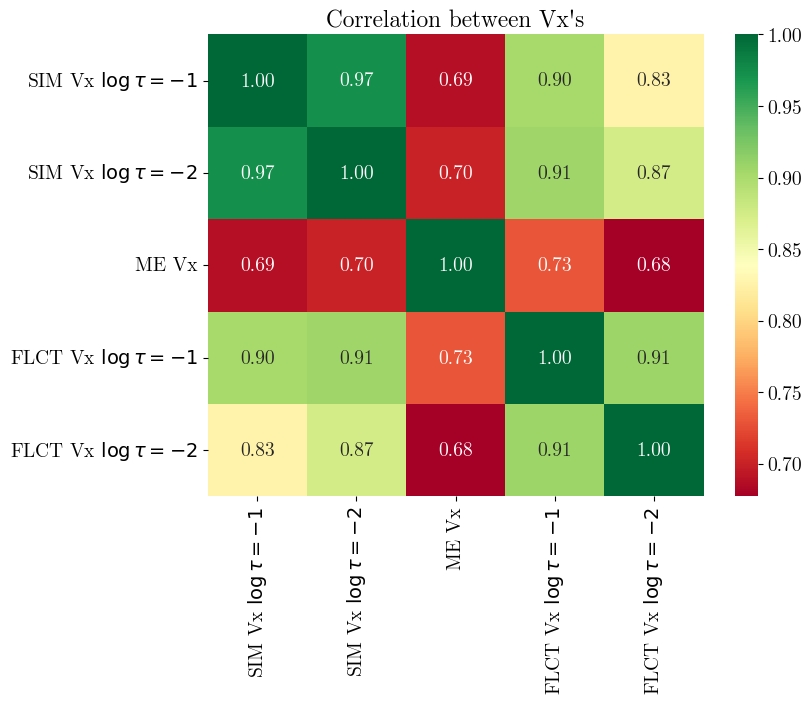

In [28]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s")
#plt.savefig("Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

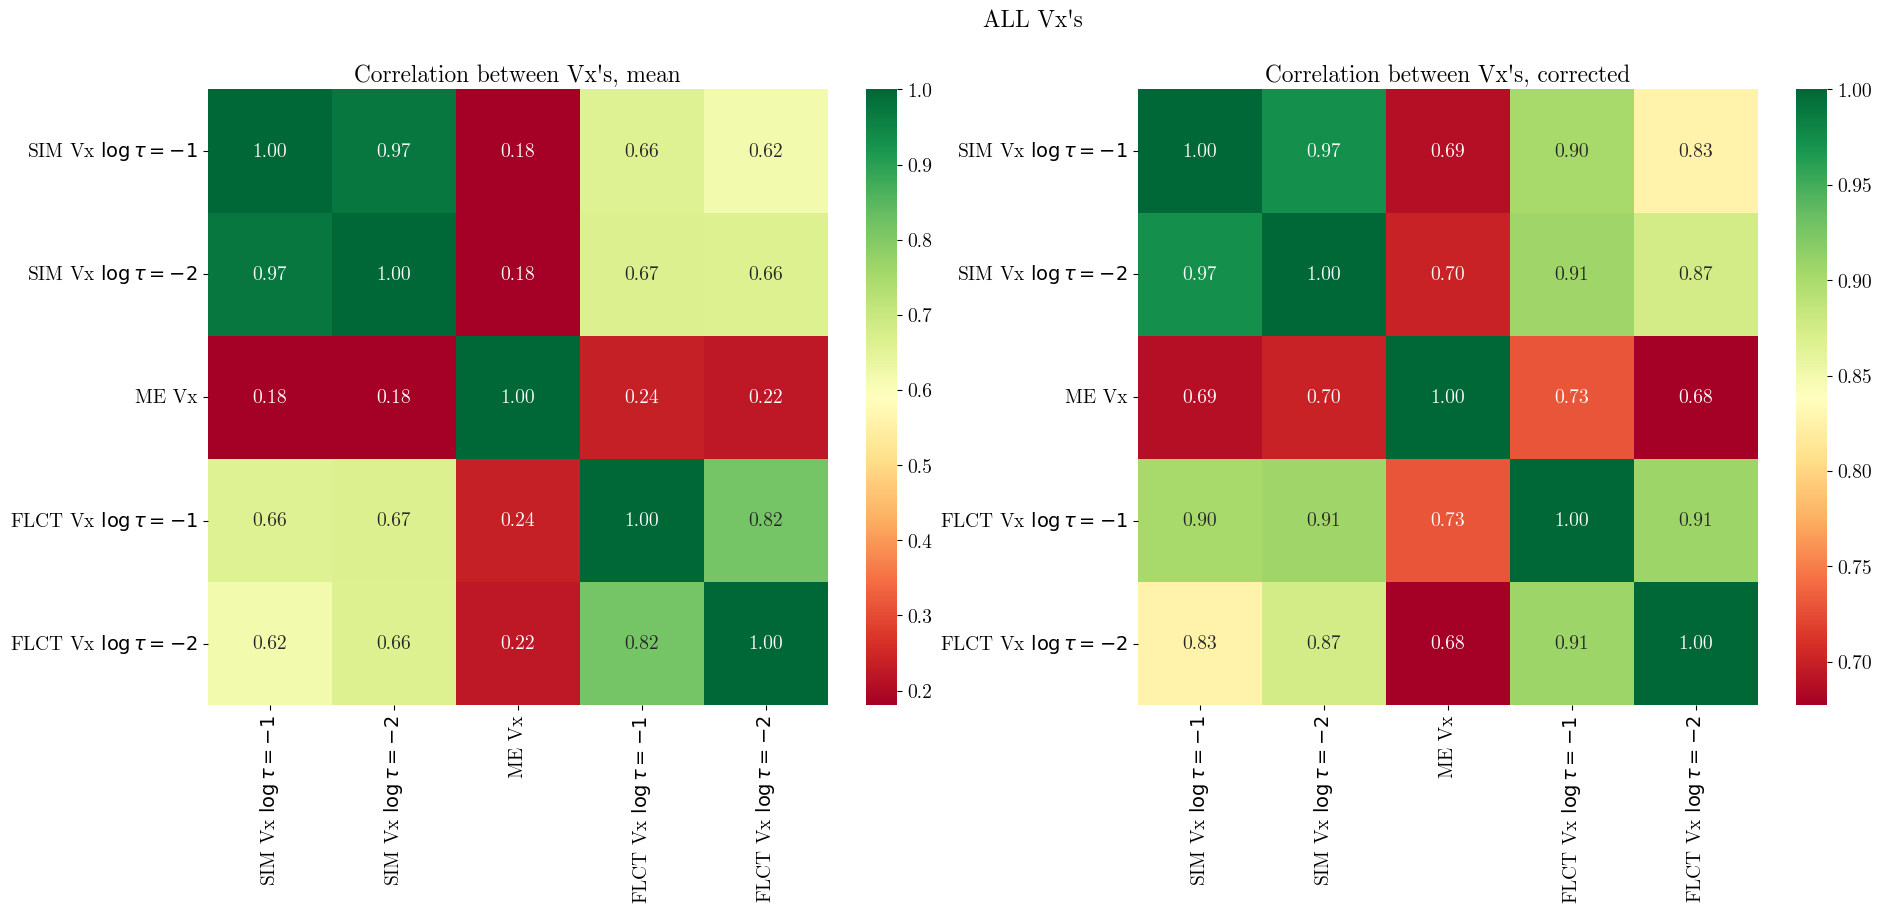

In [29]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

In [30]:
Vxm3 = fits.open("VelocitiesRS_TAU_0_001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym3 = fits.open("VelocitiesRS_TAU_0_001.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm3 = fits.open("VelocitiesRS_TAU_0_001.fits")[2].data
Vxm3 = Vxm3[::3,::2,::2]/1E5
Vym3 = Vym3[::3,::2,::2]/1E5
Vzm3 = Vzm3[::3,::2,::2]/1E5
#Vxm3 = Vxm3.transpose(0, 2, 1)
#Vym3 = Vym3.transpose(0, 2, 1)
#Vzm3 = Vzm3.transpose(0, 2, 1)

In [31]:
Vxm3_mean = temporal_avg(Vxm3, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym3_mean = temporal_avg(Vym3, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [32]:
Vxm3_filtered600 = gaussian_filter(Vxm3_mean, 22.5/2, mode = "wrap")
Vym3_filtered600 = gaussian_filter(Vym3_mean, 22.5/2, mode = "wrap")

In [33]:
Vxm3_filtered300 = gaussian_filter(Vxm3_mean, 11.25/2, mode = "wrap")
Vym3_filtered300 = gaussian_filter(Vym3_mean, 11.25/2, mode = "wrap")

In [34]:
Vxm4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[0].data # Vx from Velocities.fits as originally thought
Vzm4 = fits.open("VelocitiesRS_TAU_0_0001.fits")[2].data
Vxm4 = Vxm4[::3,::2,::2]/1E5
Vym4 = Vym4[::3,::2,::2]/1E5
Vzm4 = Vzm4[::3,::2,::2]/1E5
#Vxm4 = Vxm4.transpose(0, 2, 1)
#Vym4 = Vym4.transpose(0, 2, 1)
#Vzm4 = Vzm4.transpose(0, 2, 1)

In [35]:
Vxm4_mean = temporal_avg(Vxm4, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym4_mean = temporal_avg(Vym4, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [36]:
Vxm4_filtered600 = gaussian_filter(Vxm4_mean, 22.5/2, mode = "wrap")
Vym4_filtered600 = gaussian_filter(Vym4_mean, 22.5/2, mode = "wrap")

In [37]:
Vxm4_filtered300 = gaussian_filter(Vxm4_mean, 11.25/2, mode = "wrap")
Vym4_filtered300 = gaussian_filter(Vym4_mean, 11.25/2, mode = "wrap")

In [38]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data

In [39]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [40]:
Vx_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[1].data

In [41]:
Vx_BzFeI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")

In [42]:
Vx_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[0].data
Vy_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[1].data

In [43]:
Vx_BzMgI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")

In [44]:
Vx_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[0].data
Vy_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[1].data

In [45]:
Vx_BzMgI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")

In [46]:
logt = [-1.0, -2.0, -3.0, -4.0]
fwhm6x_corM = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0]]

fwhm6y_corM = [pearsonr(Vym1_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0]]

fwhm3x_corM = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0]]

fwhm3y_corM = [pearsonr(Vym1_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0]]

fwhm6x_corF = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzFeI_cor.flatten())[0]]
fwhm6y_corF = [pearsonr(Vym1_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzFeI_cor.flatten())[0]]

fwhm3x_corF = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzFeI_cor3.flatten())[0]]

fwhm3y_corF = [pearsonr(Vym1_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzFeI_cor3.flatten())[0]]

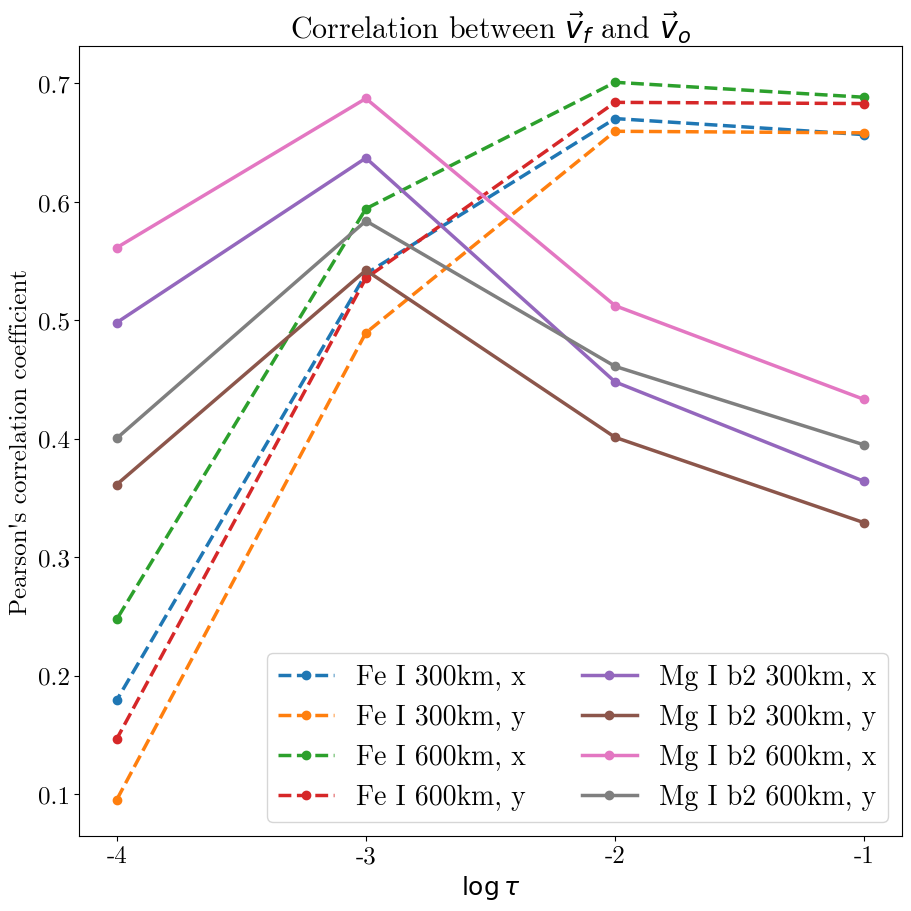

In [47]:
mpl.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize = (9, 9), layout='constrained')
ax.plot(logt, fwhm3x_corF, label="Fe I 300km, x", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3y_corF, label = "Fe I 300km, y", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6x_corF, label = "Fe I 600km, x", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6y_corF, label = "Fe I 600km, y", linestyle = "dashed", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3x_corM, label="Mg I b2 300km, x", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm3y_corM, label = "Mg I b2 300km, y", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6x_corM, label = "Mg I b2 600km, x", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.plot(logt, fwhm6y_corM, label = "Mg I b2 600km, y", linestyle = "solid", linewidth = 2.5, marker = 'o')
ax.set_ylabel("Pearson's correlation coefficient")
ax.set_title('Correlation between $\\vec{v}_f$ and $\\vec{v}_o$')
ax.set_xlabel("$\log\\tau$")
ax.set_xticks([-1,-2,-3,-4])
#ax.axvline(-4, linewidth = 2, color = "red")
#ax.axvline(-1, linewidth = 2, color = "blue")
ax.legend(loc='best', ncols=2, fontsize = 20)
#plt.savefig("Tables.png", dpi = 200, bbox_inches = 'tight')

<h1>Curl & Divergence</h1>

In [48]:
rotm1 = rotorr(Vxm1_filtered600, Vym1_filtered600, 32)
divm1 = divv(Vxm1_filtered600, Vym1_filtered600, 32)

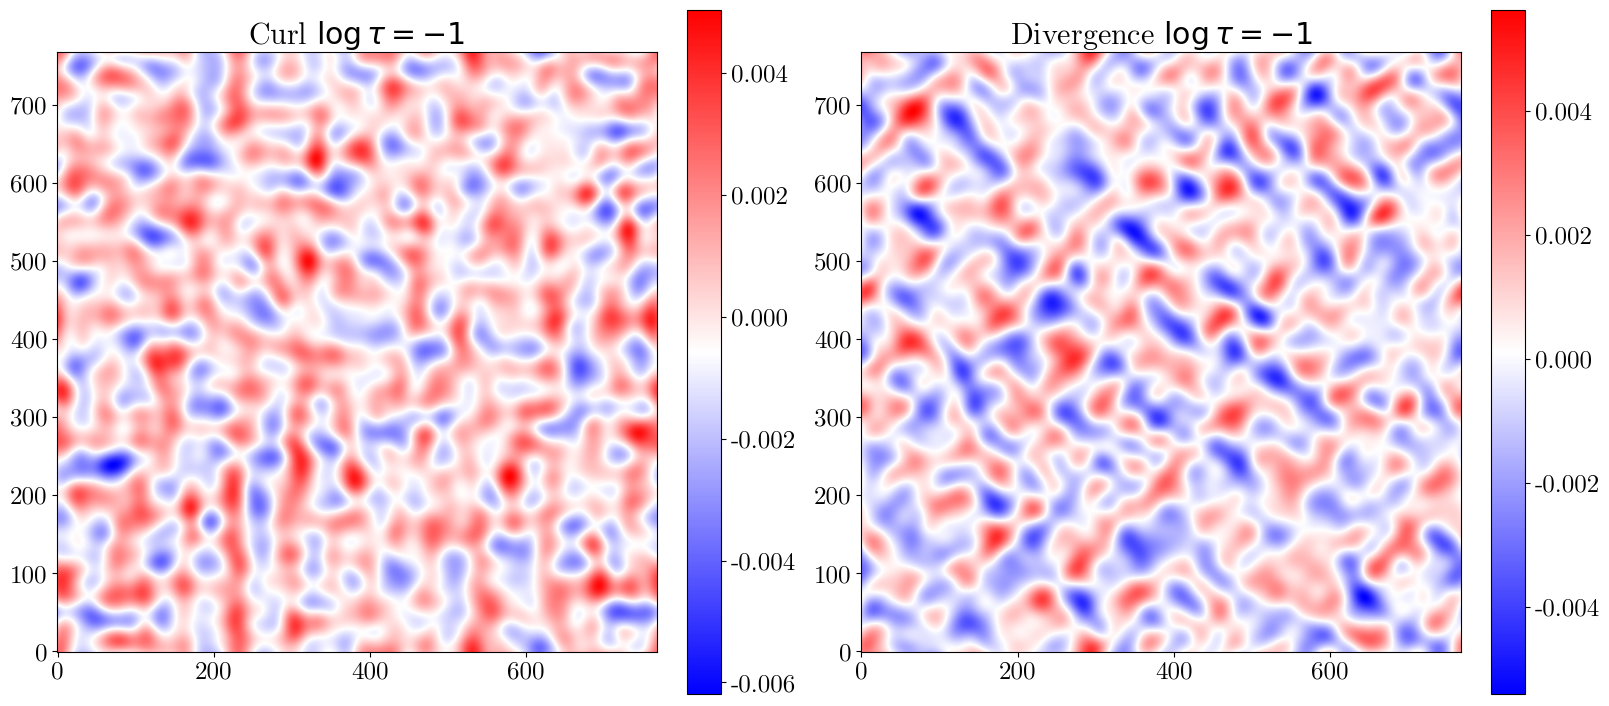

In [49]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotm1, origin = "lower", cmap = "bwr")
plt.title("Curl $\log\\tau = -1$")
plt.colorbar()
plt.subplot(122)
plt.imshow(divm1, origin = "lower", cmap = "bwr")
plt.title("Divergence $\log\\tau = -1$")
plt.colorbar()

In [50]:
rotmFe = rotorr(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)
divmFe = divv(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)

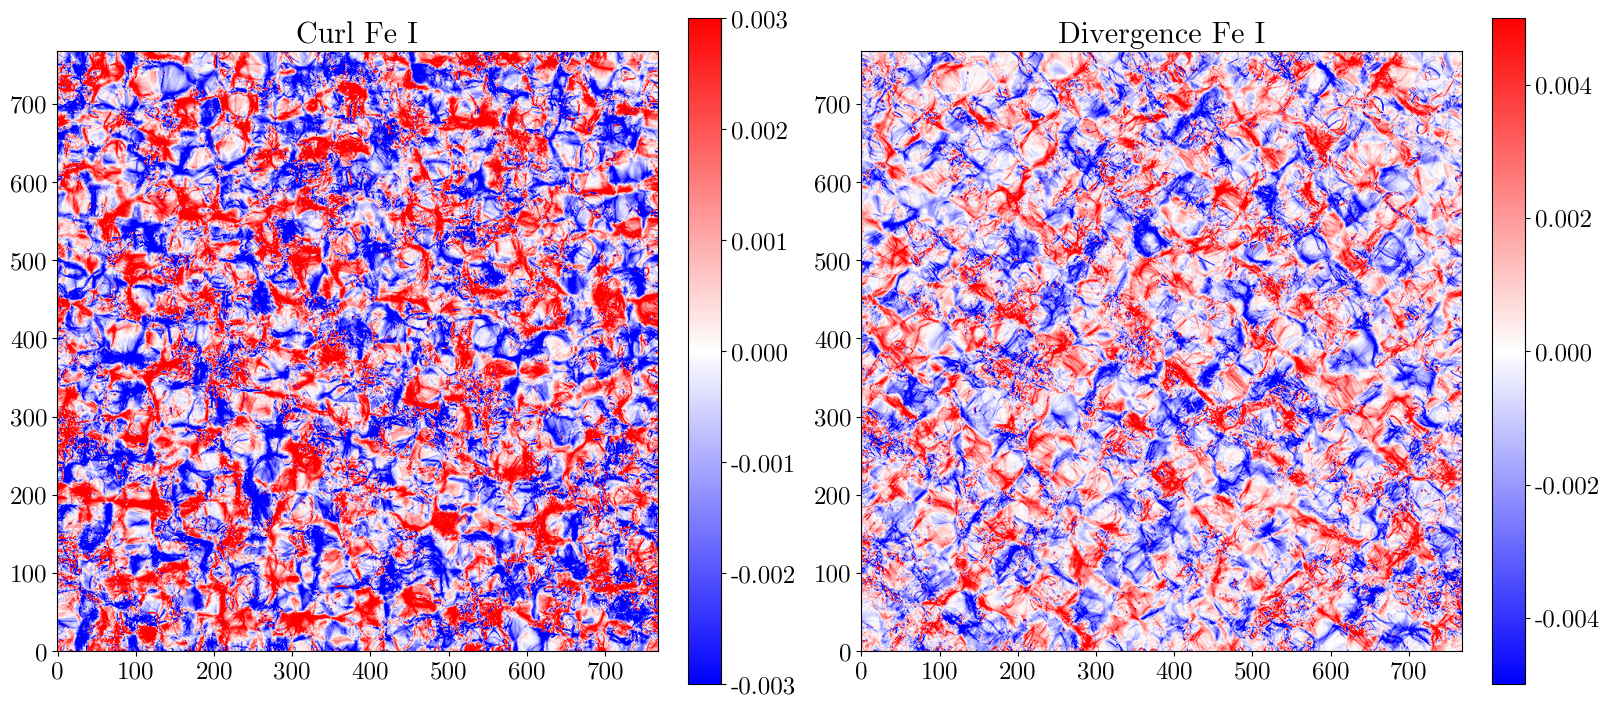

In [51]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotmFe, origin = "lower", cmap = "bwr", vmin = -0.003, vmax = 0.003)
plt.title("Curl Fe I")
plt.colorbar()
plt.subplot(122)
plt.imshow(divmFe, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Divergence Fe I")
plt.colorbar()

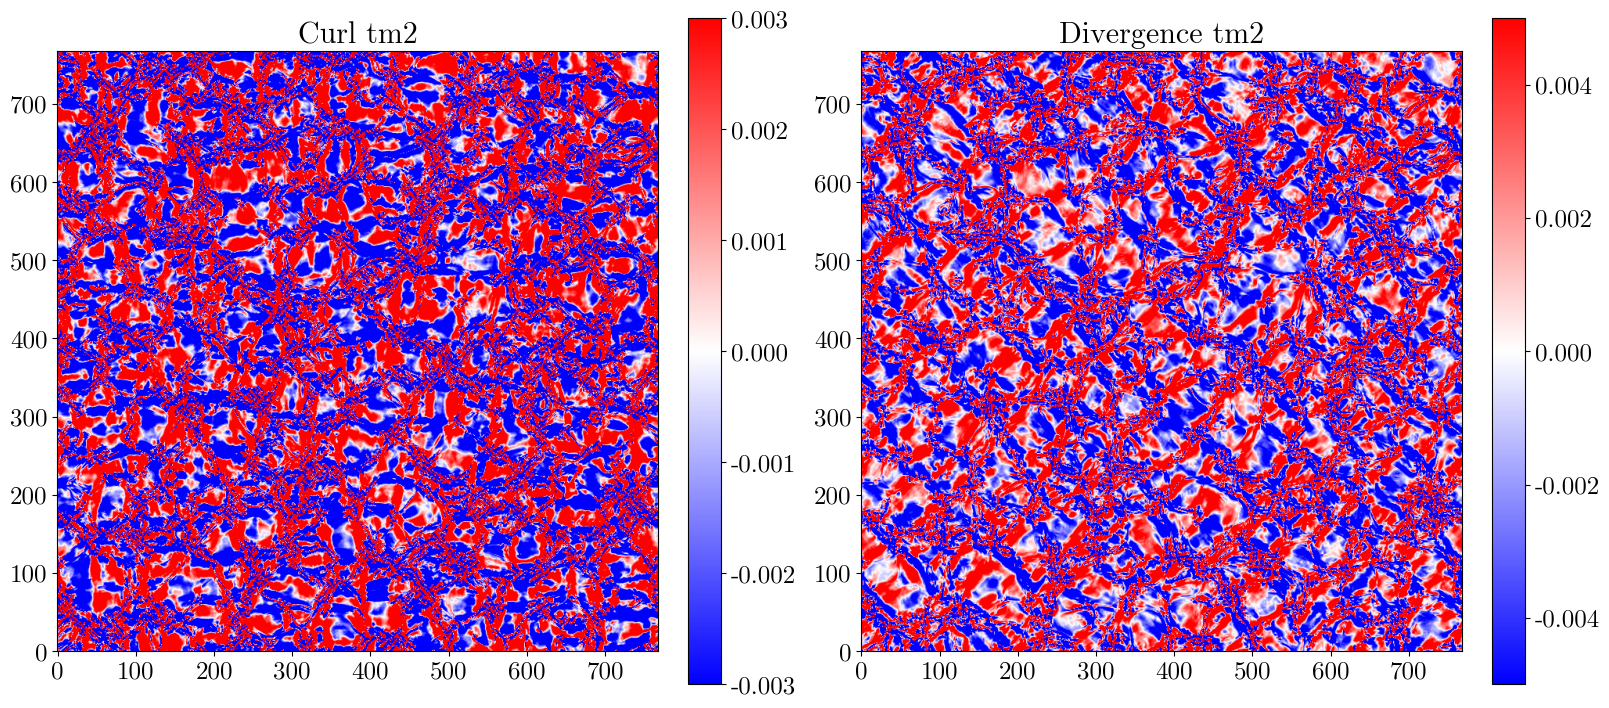

In [52]:
f = plt.figure(constrained_layout=True, figsize=(16,7))
plt.subplot(121)
plt.imshow(rotorr(Vxm2[0], Vym2[0], 32), origin = "lower", cmap = "bwr", vmin = -0.003, vmax = 0.003)
plt.title("Curl tm2")
plt.colorbar()
plt.subplot(122)
plt.imshow(divv(Vxm2[0], Vym2[0], 32), origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Divergence tm2")
plt.colorbar()

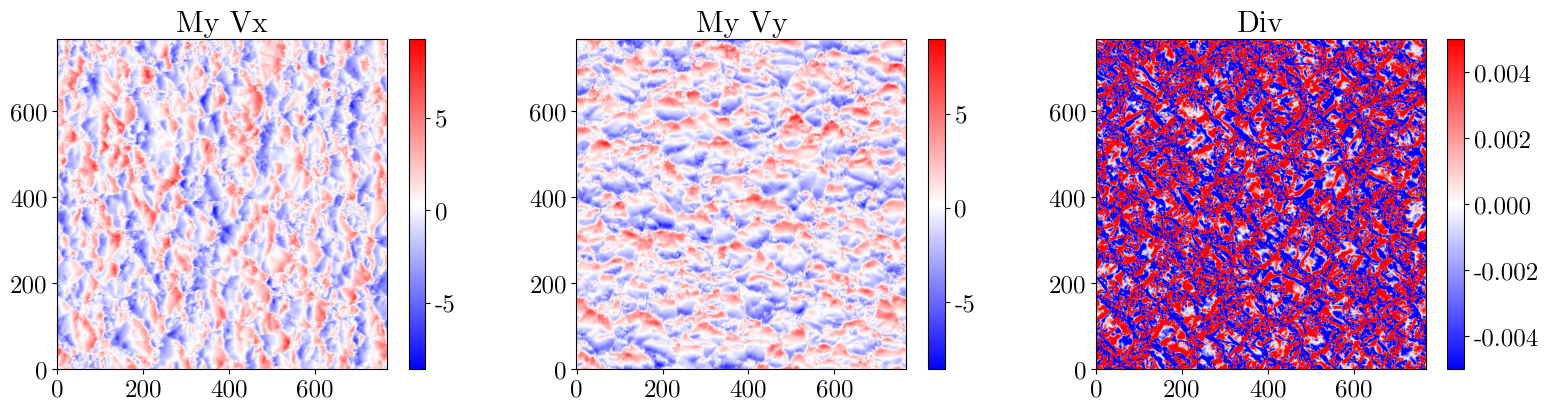

In [53]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(Vxm1[0], origin = "lower", cmap = "bwr")
plt.title("My Vx")
plt.colorbar()
plt.subplot(132)
plt.imshow(Vym1[0], origin = "lower", cmap = "bwr")
plt.title("My Vy")
plt.colorbar()
plt.subplot(133)
plt.imshow(divv(Vxm1[0], Vym1[0], 32), origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Div")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [54]:
divtm1 = divv(Vxm1_filtered600, Vym1_filtered600, 32)
rottm1 = rotorr(Vxm1_filtered600, Vym1_filtered600, 32)
PD = pearsonr(divtm1.flatten(), divmFe.flatten())
print(PD)
PR = pearsonr(rottm1.flatten(), rotmFe.flatten())
print(PR)

PearsonRResult(statistic=np.float64(0.24431445846031957), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.23144215271017524), pvalue=np.float64(0.0))


<h1>!!!Change our functions!!!</h1>

In [55]:
def novi_div(Vx, Vy, stepsize):
    dvx_dx = np.gradient(Vx, axis=1)/stepsize
    dvy_dy = np.gradient(Vy, axis=0)/stepsize

    DIV = dvx_dx + dvy_dy
    return DIV

def novi_rot(Vx, Vy, stepsize):
    dvx_dy = np.gradient(Vx, axis=0)/stepsize
    dvy_dx = np.gradient(Vy, axis=1)/stepsize

    ROTOR = dvy_dx - dvx_dy
    return ROTOR

In [56]:
rotm1N = novi_rot(Vxm1_filtered600, Vym1_filtered600, 32)
divtm1N = novi_div(Vxm1_filtered600, Vym1_filtered600, 32)

rotFeN = novi_rot(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)
divFeN = novi_div(Vx_BzFeI_cor, Vy_BzFeI_cor, 32)

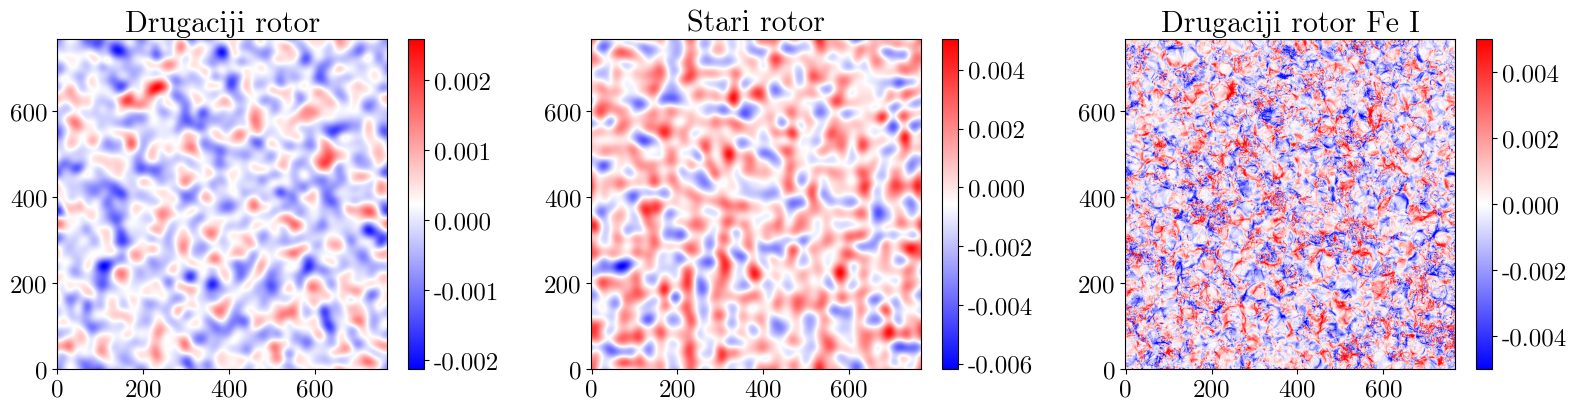

In [57]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(rotm1N, origin = "lower", cmap = "bwr")
plt.title("Drugaciji rotor")
plt.colorbar()
plt.subplot(132)
plt.imshow(rottm1, origin = "lower", cmap = "bwr")
plt.title("Stari rotor")
plt.colorbar()
plt.subplot(133)
plt.imshow(rotFeN, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Drugaciji rotor Fe I")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

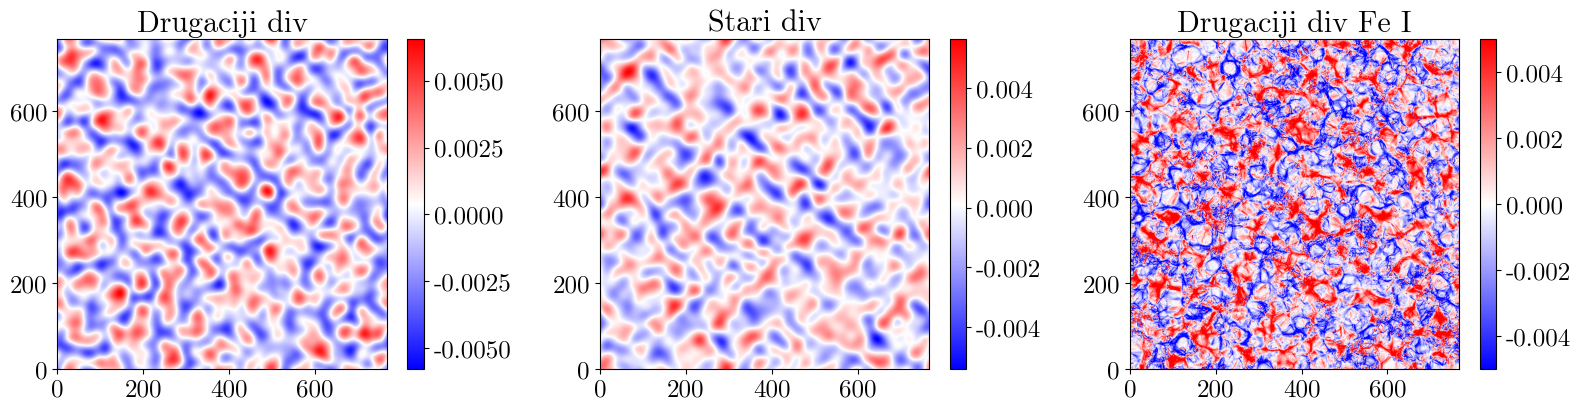

In [58]:
f = plt.figure(constrained_layout=True, figsize=(16,4))
plt.subplot(131)
plt.imshow(divtm1N, origin = "lower", cmap = "bwr")
plt.title("Drugaciji div")
plt.colorbar()
plt.subplot(132)
plt.imshow(divtm1, origin = "lower", cmap = "bwr")
plt.title("Stari div")
plt.colorbar()
plt.subplot(133)
plt.imshow(divFeN, origin = "lower", cmap = "bwr", vmin = -0.005, vmax = 0.005)
plt.title("Drugaciji div Fe I")
plt.colorbar()
#plt.savefig("BrzineDD1.png", dpi = 50, bbox_inches = "tight")

In [59]:
print("Novo poredjenje:")
print("Divergencija")
print(pearsonr(divtm1N.flatten(), divFeN.flatten()))
print("Rotor")
print(pearsonr(rotm1N.flatten(), rotFeN.flatten()))
print("-----------------------")
print("Staro poredjenje:")
print("Divergencija")
print(PD)
print("Rotor")
print(PR)

Novo poredjenje:
Divergencija
PearsonRResult(statistic=np.float64(0.29453844787271616), pvalue=np.float64(0.0))
Rotor
PearsonRResult(statistic=np.float64(0.11421371893339914), pvalue=np.float64(0.0))
-----------------------
Staro poredjenje:
Divergencija
PearsonRResult(statistic=np.float64(0.24431445846031957), pvalue=np.float64(0.0))
Rotor
PearsonRResult(statistic=np.float64(0.23144215271017524), pvalue=np.float64(0.0))


<h1>-------------------------</h1>